In [19]:
!pip install selenium
!pip install beautifulsoup4

In [243]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.expected_conditions import (
    presence_of_element_located)
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.chrome.options import Options  
import time
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
import math

In [2]:
def get_top_25_grossing_movies_url_and_tickets_sold_by_year(year):#gets the url and number of tickets sold by year from the-number.com
    chrome_options = Options() #let us set options for our chrome driver 
    chrome_options.add_argument("--headless")  #this option restrain the driver from opening a browser window
    driver = webdriver.Chrome('/usr/local/bin/chromedriver',options=chrome_options)  # Optional argument, to prevent chromedriver from opening a web browser.
    driver.get(f"https://www.the-numbers.com/market/{year}/top-grossing-movies");
    wait = WebDriverWait(driver, 5) # wait, to make sure dynamic content is complete loading before scrapping the page
    top_25_movies_url = []
    table = driver.find_element_by_tag_name('table') #getting the table element with the movie info
    trs = table.find_elements_by_tag_name('tr') # getting the table rows inside the table element
    for index in range(1,25): #iteriting on the first 50 movies, starting with tr[1] since the tr[0] contains the headers
        tds = trs[index].find_elements_by_tag_name('td') #getting the td containing the a tag with the url to the movie details
        url = tds[1].find_element_by_tag_name('a').get_attribute('href')#getting the link to visit to scrape the information
        tickets_sold =  int(tds[6].get_attribute('innerHTML').replace(',',''))
        top_25_movies_url.append({'url':url,'tickets sold':tickets_sold})
        
    driver.quit()
    return top_25_movies_url

def get_movies_details_by_url(url):#return the movie data, provide an the-number.com movie url
    chrome_options = Options()   #let us set options for our chrome driver 
    chrome_options.add_argument("--headless") #this option restrain the driver from opening a browser window
    driver = webdriver.Chrome('/usr/local/bin/chromedriver',options=chrome_options)  # Optional argument, to prevent chromedriver from opening a web browser.
    driver.get(url);#opens the driver on the url pass as an arguments,expected a the-number.com movie page
    wait = WebDriverWait(driver, 5)#wait for the page to load dynamic content before start scrapping
    title = driver.find_element_by_css_selector('#main > div > h1').get_attribute('innerHTML')[0:-7:]#  find the element with the movie title and retrieve the text
    table = driver.find_element_by_css_selector('table#movie_finances') #find the table with the wanted information 
    tds = table.find_elements_by_css_selector('td.data') #find the cells with the wanted information
    domestic_gross = int(tds[0].get_attribute('innerHTML').replace('$','').replace(',',''))#retrieve the value in that cell, and cleaned it before converting it to int
    international_gross = int(tds[1].get_attribute('innerHTML').replace('$','').replace(',',''))#retrieve the value in that cell, and cleaned it before converting it to int
    worldwide_gross = int(tds[2].get_attribute('innerHTML').replace('$','').replace(',',''))#retrieve the value in that cell, and cleaned it before converting it to int
    source = driver.find_element_by_xpath("//*[contains(text(),'Source:')]/../..").find_element_by_tag_name('a').get_attribute('innerHTML') #find the source of the movie, e.g. comic adaptation
    genre = driver.find_element_by_xpath("//*[contains(text(),'Genre:')]/../..").find_element_by_tag_name('a').get_attribute('innerHTML')#find the main genre of the movie
    studio= driver.find_element_by_xpath("//*[contains(text(),'Production Companies:')]/../..").find_element_by_tag_name('a').get_attribute('innerHTML') #find the studio
    movie_data = np.array([title,domestic_gross,international_gross,worldwide_gross,source,genre,studio]) #convert de data retrieve into an np.array
    driver.quit()#quit the driver 
    return movie_data 

def get_top_25_movie_data_by_year(year): # uses the two above methods to get the info of the top 25 movies from an specific year from the-number.com
    urls_and_tikects= get_top_25_grossing_movies_url_and_tickets_sold_by_year(year)#get url and tickets sold of the top 25 movies of the specified year
    movies_data = [] # will be use to collect all the data
    for url_and_tikect in urls_and_tikects:#iterate over the collection of urls and tickects sold 
        movie_data = np.append( get_movies_details_by_url(url_and_tikect['url']),[url_and_tikect['tickets sold']])#gets the movie data and add the tickets sold to it
        movies_data.append(movie_data)#append the movie data to our list of movies 

    return movies_data #return the array with the collection the data of the top 25 movies of the specified year

In [3]:
use_cols =['Title','Domestic Gross','International Gross','Worldwide Gross','Source','Genre','Studio','Tickets Sold'] 
movies_data_2019 = get_top_25_movie_data_by_year(2019)
df_2019= pd.DataFrame(movies_data_2019,index=list(range(1,len(movies_data_2019)+1)), columns=use_cols)

In [4]:
df_2019

,Title,Domestic Gross,International Gross,Worldwide Gross,Source,Genre,Studio,Tickets Sold
1,Avengers: Endgame,858373000,1939427564,2797800564,Based on Comic/Graphic Novel,Action,Marvel Studios,94223161
2,The Lion King,543638043,1112503536,1656141579,Remake,Adventure,Walt Disney Pictures,59674868
3,Frozen II,477373578,970176133,1447549711,Original Screenplay,Adventure,Walt Disney Animation Studios,49444515
4,Toy Story 4,434038008,639356805,1073394813,Original Screenplay,Adventure,Disney-Pixar,47644128
5,Captain Marvel,426829839,702900000,1129729839,Based on Comic/Graphic Novel,Action,Marvel Studios,46852891
6,Star Wars: The Rise of Skywalker,515202542,557741680,1072944222,Original Screenplay,Adventure,Lucasfilm,42887622
7,Spider-Man: Far From Home,390532085,739418016,1129950101,Based on Comic/Graphic Novel,Action,Columbia Pictures,42868505
8,Aladdin,355559216,693111150,1048670366,Remake,Adventure,Walt Disney Pictures,39029552
9,Joker,335451311,737271282,1072722593,Based on Comic/Graphic Novel,Thriller/Suspense,Village Roadshow Productions,36638036
10,It: Chapter Two,211593228,257973578,469566806,Original Screenplay,Horror,New Line Cinema,23226479


In [5]:
#df_2019[['Domestic Gross', 'International Gross', 'Worldwide Gross', 'Tickets Sold']] = df_2019[['Domestic Gross', 'International Gross', 'Worldwide Gross', 'Tickets Sold']].apply(pd.to_numeric) 
#df_2019


In [6]:
movies_data_2018 = get_top_25_movie_data_by_year(2018)
df_2018= pd.DataFrame(movies_data_2018,index=list(range(1,len(movies_data_2018)+1)), columns=use_cols)
df_2018

,Title,Domestic Gross,International Gross,Worldwide Gross,Source,Genre,Studio,Tickets Sold
1,Black Panther,700059566,641852753,1341912319,Based on Comic/Graphic Novel,Action,Marvel Studios,76845177
2,Avengers: Infinity War,678815482,1369544272,2048359754,Based on Comic/Graphic Novel,Action,Marvel Studios,74513225
3,Incredibles 2,608581744,634223615,1242805359,Original Screenplay,Adventure,Disney-Pixar,66803704
4,Jurassic World: Fallen Kingdom,417719760,890614245,1308334005,Based on Fiction Book/Short Story,Action,Universal Pictures,45852883
5,Deadpool 2,324591735,462088822,786680557,Based on Comic/Graphic Novel,Action,Marvel Studios,35621600
6,Dr. Seuss’ The Grinch,270620950,241048559,511669509,Based on Fiction Book/Short Story,Adventure,Universal Pictures,29229463
7,Jumanji: Welcome to the Jungle,404508916,556721277,961230193,Original Screenplay,Adventure,Columbia Pictures,25851411
8,Mission: Impossible—Fallout,220159104,567017625,787176729,Based on TV,Action,Skydance Productions,24166751
9,Ant-Man and the Wasp,216648740,406495920,623144660,Based on Comic/Graphic Novel,Action,Marvel Studios,23781420
10,Solo: A Star Wars Story,213767512,179383835,393151347,Spin-Off,Adventure,Lucasfilm,23465149


In [7]:
movies_data_2017 = get_top_25_movie_data_by_year(2017)
df_2017= pd.DataFrame(movies_data_2017,index=list(range(1,len(movies_data_2017)+1)), columns=use_cols)
df_2017

,Title,Domestic Gross,International Gross,Worldwide Gross,Source,Genre,Studio,Tickets Sold
1,Star Wars Ep. VIII: The Last Jedi,620181382,712358507,1332539889,Original Screenplay,Adventure,Lucasfilm,57660910
2,Beauty and the Beast,504014165,752142162,1256156327,Remake,Musical,Walt Disney Pictures,56188870
3,Wonder Woman,412563408,408569970,821133378,Based on Comic/Graphic Novel,Action,Warner Bros.,45993691
4,Guardians of the Galaxy Vol 2,389813101,479300000,869113101,Based on Comic/Graphic Novel,Action,Marvel Studios,43457424
5,Spider-Man: Homecoming,334201140,545965210,880166350,Based on Comic/Graphic Novel,Action,Marvel Studios,37257652
6,It,328828874,372891173,701720047,Remake,Horror,Lin Pictures,36508556
7,Thor: Ragnarok,315058289,538900000,853958289,Based on Comic/Graphic Novel,Action,Marvel Studios,34696226
8,Despicable Me 3,264624300,770063549,1034687849,Original Screenplay,Adventure,Universal Pictures,29501036
9,Logan,226277068,387951364,614228432,Based on Comic/Graphic Novel,Action,Marvel Studios,25225983
10,The Fate of the Furious,225764765,1010939031,1236703796,Original Screenplay,Action,Universal Pictures,25168870


In [8]:
movies_data_2016 = get_top_25_movie_data_by_year(2016)
df_2016= pd.DataFrame(movies_data_2016,index=list(range(1,len(movies_data_2016)+1)), columns=use_cols)
df_2016

,Title,Domestic Gross,International Gross,Worldwide Gross,Source,Genre,Studio,Tickets Sold
1,Finding Dory,486295561,539068066,1025363627,Original Screenplay,Adventure,Disney-Pixar,56219140
2,Rogue One: A Star Wars Story,532177324,523879949,1056057273,Spin-Off,Adventure,Lucasfilm,49131526
3,Captain America: Civil War,408084349,745200000,1153284349,Based on Comic/Graphic Novel,Action,Marvel Studios,47177381
4,The Secret Life of Pets,368384330,518222082,886606412,Original Screenplay,Adventure,Illumination Entertainment,42587783
5,The Jungle Book,364001123,596358986,960360109,Based on Fiction Book/Short Story,Adventure,Walt Disney Pictures,42081054
6,Deadpool,363070709,421954884,785025593,Based on Comic/Graphic Novel,Action,Marvel Studios,41973492
7,Zootopia,341268248,666605947,1007874195,Original Screenplay,Adventure,Walt Disney Pictures,39452976
8,Batman v Superman: Dawn of Justice,330360194,542034897,872395091,Based on Comic/Graphic Novel,Action,Warner Bros.,38191930
9,Suicide Squad,325100054,421746840,746846894,Based on Comic/Graphic Novel,Action,Warner Bros.,37583821
10,Doctor Strange,232641920,443762646,676404566,Based on Comic/Graphic Novel,Action,Marvel Studios,26602056


In [9]:
movies_data_2015 = get_top_25_movie_data_by_year(2015)
df_2015= pd.DataFrame(movies_data_2015,index=list(range(1,len(movies_data_2015)+1)), columns=use_cols)
df_2015

,Title,Domestic Gross,International Gross,Worldwide Gross,Source,Genre,Studio,Tickets Sold
1,Star Wars Ep. VII: The Force Awakens,936662225,1128815859,2065478084,Original Screenplay,Adventure,Lucasfilm,88043765
2,Jurassic World,652270625,1018130012,1670400637,Based on Fiction Book/Short Story,Action,Universal Pictures,77374926
3,Avengers: Age of Ultron,459005868,937093334,1396099202,Based on Comic/Graphic Novel,Action,Marvel Studios,54449094
4,Inside Out,356461711,498748492,855210203,Original Screenplay,Adventure,Disney-Pixar,42284900
5,Furious 7,353007020,1165715774,1518722794,Original Screenplay,Action,Original Film,41875091
6,American Sniper,350126372,197200000,547326372,Based on Factual Book/Article,Drama,Mad Chance,41268930
7,Minions,336045770,823585370,1159631140,Spin-Off,Adventure,Universal Pictures,39863081
8,The Hunger Games: Mockingjay - Part 2,281723902,367262885,648986787,Based on Fiction Book/Short Story,Thriller/Suspense,Lionsgate,32524957
9,The Martian,228433663,426837780,655271443,Based on Fiction Book/Short Story,Thriller/Suspense,Scott Free Films,26731359
10,Cinderella,201151353,333400000,534551353,Based on Folk Tale/Legend/Fairytale,Drama,Allison Shearmur,23861370


In [10]:
movies_data_2020 = get_top_25_movie_data_by_year(2020)
df_2020= pd.DataFrame(movies_data_2020,index=list(range(1,len(movies_data_2020)+1)), columns=use_cols)
df_2020

,Title,Domestic Gross,International Gross,Worldwide Gross,Source,Genre,Studio,Tickets Sold
1,Bad Boys For Life,204417855,220181959,424599814,Original Screenplay,Action,Columbia Pictures,22438842
2,1917,159227644,208205395,367433039,Original Screenplay,Thriller/Suspense,Dreamworks LLC,17332762
3,Sonic The Hedgehog,146066470,159750500,305816970,Based on Game,Adventure,Marza Animation Planet,16033641
4,Jumanji: The Next Level,316831246,480342830,797174076,Original Screenplay,Adventure,7 Bucks Productions,13692284
5,Star Wars: The Rise of Skywalker,515202542,557741680,1072944222,Original Screenplay,Adventure,Lucasfilm,13665895
6,Birds of Prey (And the Fantabulous Emancipatio...,84158461,117700000,201858461,Based on Comic/Graphic Novel,Action,LuckyChap Entertainment,9238030
7,Dolittle,77047065,172387935,249435000,Based on Fiction Book/Short Story,Adventure,Team Downey,8457416
8,The Invisible Man,64914050,69243994,134158044,Based on Fiction Book/Short Story,Horror,Goalpost Pictures,7125581
9,The Call of the Wild,62342368,45039407,107381775,Based on Fiction Book/Short Story,Adventure,20th Century Studios,6843289
10,Onward,61555145,46299704,107854849,Original Screenplay,Adventure,Walt Disney Pictures,6756876


In [11]:
df_2016.astype({'Domestic Gross': 'int64','International Gross': 'int64','Worldwide Gross': 'int64','Tickets Sold': 'int64'}).groupby('Genre').agg({'Domestic Gross':'sum', 'International Gross': 'sum','Tickets Sold':'sum'})

,Domestic Gross,International Gross,Tickets Sold
Genre,,,
Action,1976892635,3215769720,228249535
Adventure,4299520409,6230233236,385026506
Comedy,255791445,190412018,29571265
Drama,125070033,113454523,14448131
Musical,248757044,387679108,24282787


In [12]:
df_2016 = df_2016.astype({'Domestic Gross': 'int64','International Gross': 'int64','Worldwide Gross': 'int64','Tickets Sold': 'int64'})
df_2016

,Title,Domestic Gross,International Gross,Worldwide Gross,Source,Genre,Studio,Tickets Sold
1,Finding Dory,486295561,539068066,1025363627,Original Screenplay,Adventure,Disney-Pixar,56219140
2,Rogue One: A Star Wars Story,532177324,523879949,1056057273,Spin-Off,Adventure,Lucasfilm,49131526
3,Captain America: Civil War,408084349,745200000,1153284349,Based on Comic/Graphic Novel,Action,Marvel Studios,47177381
4,The Secret Life of Pets,368384330,518222082,886606412,Original Screenplay,Adventure,Illumination Entertainment,42587783
5,The Jungle Book,364001123,596358986,960360109,Based on Fiction Book/Short Story,Adventure,Walt Disney Pictures,42081054
6,Deadpool,363070709,421954884,785025593,Based on Comic/Graphic Novel,Action,Marvel Studios,41973492
7,Zootopia,341268248,666605947,1007874195,Original Screenplay,Adventure,Walt Disney Pictures,39452976
8,Batman v Superman: Dawn of Justice,330360194,542034897,872395091,Based on Comic/Graphic Novel,Action,Warner Bros.,38191930
9,Suicide Squad,325100054,421746840,746846894,Based on Comic/Graphic Novel,Action,Warner Bros.,37583821
10,Doctor Strange,232641920,443762646,676404566,Based on Comic/Graphic Novel,Action,Marvel Studios,26602056


In [13]:
df_2016.dtypes

Title                  object
Domestic Gross          int64
International Gross     int64
Worldwide Gross         int64
Source                 object
Genre                  object
Studio                 object
Tickets Sold            int64
dtype: object

In [14]:
pd.options.display.float_format = "{:,.2f}".format
df_2016.describe()

,Domestic Gross,International Gross,Worldwide Gross,Tickets Sold
count,24.00,24.00,24.00,24.00
mean,"287,751,315.25","422,397,858.54","710,149,173.79","28,399,092.67"
std,"182,918,620.83","235,130,196.09","405,133,278.78","13,103,208.34"
min,"125,070,033.00","89,753,934.00","217,194,805.00","14,448,131.00"
25%,"155,008,632.75","246,046,288.00","399,351,743.25","17,816,697.50"
50%,"241,397,309.50","404,712,974.00","656,420,359.00","23,381,467.50"
75%,"363,303,312.50","539,809,773.75","905,044,836.25","40,083,105.00"
max,"936,662,225.00","1,128,815,859.00","2,065,478,084.00","56,219,140.00"


In [15]:
def get_genre_urls ():
    chrome_options = Options()  
    chrome_options.add_argument("--headless") 
    driver = webdriver.Chrome('/usr/local/bin/chromedriver',options=chrome_options)  # Optional argument, to prevent chromedriver from opening a web browser.
    driver.get('https://www.the-numbers.com/market/genres');
    wait = WebDriverWait(driver, 5) # wait, to make sure dynamic content is complete loading before scrapping the page
    genre_urls = []
    table = driver.find_element_by_tag_name('table') #getting the table element with the movie info
    trs = table.find_elements_by_tag_name('tr') # getting the table rows inside the table element
    for index in range(1,len(trs)): #iteriting on the first 50 movies, starting with tr[1] since the tr[0] contains the headers
        url = trs[index].find_element_by_tag_name('a').get_attribute('href') #getting the td containing the a tag with the url to the movie details
        genre = trs[index].find_element_by_tag_name('a').get_attribute('innerHTML') #getting the td containing the a tag with the url to the movie details
        genre_urls.append({genre:url})
    driver.quit()
    return genre_urls


urls_by_genre = get_genre_urls()



In [16]:
chrome_options = Options()  
chrome_options.add_argument("--headless") 
driver = webdriver.Chrome('/usr/local/bin/chromedriver',options=chrome_options)  # Optional argument, to prevent chromedriver from opening a web browser.
genre_info = {}
for item in urls_by_genre:
    genre = list(item.keys())[0]
    url = list(item.values())[0]
    driver.get(url);
    wait = WebDriverWait(driver, 5)
    table = driver.find_element_by_css_selector('#page_filling_chart > table:nth-child(4)')
    trs = table.find_elements_by_tag_name('tr')
    info = []
   
    for index in range(len(trs)-6,len(trs)):
        if(genre == "Musical"):
            index = index-1
        if(genre == "Reality"):
            continue
        tds = trs[index].find_elements_by_tag_name('td')
        year = tds[0].find_element_by_tag_name('a').get_attribute('innerHTML')
        movies_release = tds[1].find_element_by_tag_name('a').get_attribute('innerHTML')
        market_share= tds[2].find_element_by_tag_name('b').get_attribute('innerHTML')
        gross=tds[3].get_attribute('innerHTML').replace('$',"").replace(',',"")
        tickets_sold=tds[4].get_attribute('innerHTML').replace(',',"")
        info.append([year,movies_release,market_share,gross,tickets_sold])
    genre_info[genre] = info
driver.close()
driver.quit()


    

In [168]:
usecols = ['Year','Movies Release','Market Share','Domestic Gross','Tickets Sold']
genre_avg_gross = {}
adventure_market_share_df = pd.DataFrame(genre_info['Adventure'],index=list(range(1,len(genre_info['Adventure'])+1)), columns=usecols)
genre_avg_gross['Adventure']= adventure_market_share_df['Domestic Gross'].astype('int64').mean()



In [169]:
action_market_share_df = pd.DataFrame(genre_info['Action'],index=list(range(1,len(genre_info['Action'])+1)), columns=usecols)
genre_avg_gross['Action']= action_market_share_df['Domestic Gross'].astype('int64').mean()


In [170]:
drama_market_share_df = pd.DataFrame(genre_info['Drama'],index=list(range(1,len(genre_info['Drama'])+1)), columns=usecols)
genre_avg_gross['Drama'] = drama_market_share_df['Domestic Gross'].astype('int64').mean()


In [171]:
comedy_market_share_df = pd.DataFrame(genre_info['Comedy'],index=list(range(1,len(genre_info['Comedy'])+1)), columns=usecols)
genre_avg_gross['Comedy'] = comedy_market_share_df['Domestic Gross'].astype('int64').mean()

In [172]:
thriller_market_share_df = pd.DataFrame(genre_info['Thriller/Suspense'],index=list(range(1,len(genre_info['Thriller/Suspense'])+1)), columns=usecols)
genre_avg_gross['Thriller/Suspense'] = thriller_market_share_df['Domestic Gross'].astype('int64').mean()


In [173]:
Horror_market_share_df = pd.DataFrame(genre_info['Horror'],index=list(range(1,len(genre_info['Horror'])+1)), columns=usecols)
genre_avg_gross['Horror'] = Horror_market_share_df['Domestic Gross'].astype('int64').mean()



In [174]:
romantic_comedy_market_share_df = pd.DataFrame(genre_info['Romantic Comedy'],index=list(range(1,len(genre_info['Romantic Comedy'])+1)), columns=usecols)
genre_avg_gross['Romantic Comedy'] = romantic_comedy_market_share_df['Domestic Gross'].astype('int64').mean()



In [175]:
musical_market_share_df = pd.DataFrame(genre_info['Musical'],index=list(range(1,len(genre_info['Musical'])+1)), columns=usecols)
genre_avg_gross['Musical'] = musical_market_share_df['Domestic Gross'].astype('int64').mean()


In [176]:
documentary_market_share_df = pd.DataFrame(genre_info['Documentary'],index=list(range(1,len(genre_info['Documentary'])+1)), columns=usecols)
genre_avg_gross['Documentary'] = documentary_market_share_df['Domestic Gross'].astype('int64').mean()


In [177]:
genre_avg_gross

{'Adventure': 2887874205.0,
 'Action': 2675189931.1666665,
 'Drama': 1331144261.0,
 'Comedy': 855949863.5,
 'Thriller/Suspense': 750651824.3333334,
 'Horror': 617162948.1666666,
 'Romantic Comedy': 110640897.16666667,
 'Musical': 322460679.5,
 'Documentary': 59766551.333333336}

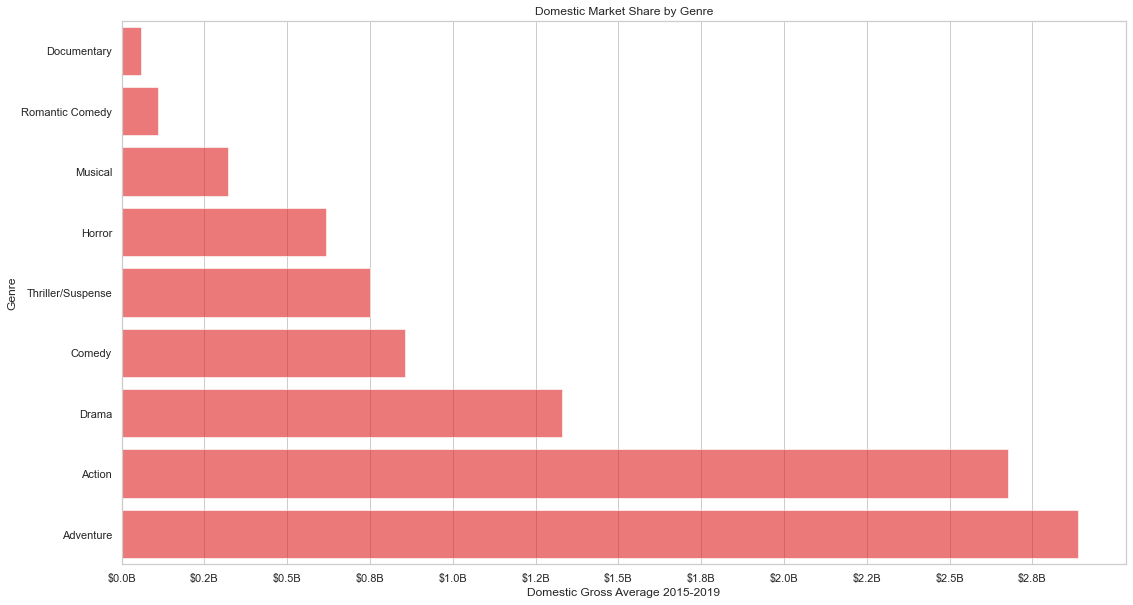

In [225]:
%matplotlib inline


def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fM' % (x*1e-6)

def billions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fB' % (x*1e-9)

f, ax = plt.subplots(figsize=(18, 10))
y_values = list(genre_avg_gross.keys()) 
x_values = list(genre_avg_gross.values()) 
domestic_market_share_by_genre = pd.DataFrame(data= {'Genre':y_values,'Average Gross':x_values}).sort_values(by=['Average Gross'])
barplot = sns.barplot(x='Average Gross',y='Genre',data=domestic_market_share_by_genre, orient="h",color="red" , alpha=0.6)
plt.title("Domestic Market Share by Genre")
barplot.set_xlabel("Domestic Gross Average 2015-2019")
barplot.set_ylabel("Genre")
barplot.set_xticks(np.arange(0, max(x_values), step=250000000))
barplot.xaxis.set_major_formatter( FuncFormatter(billions))



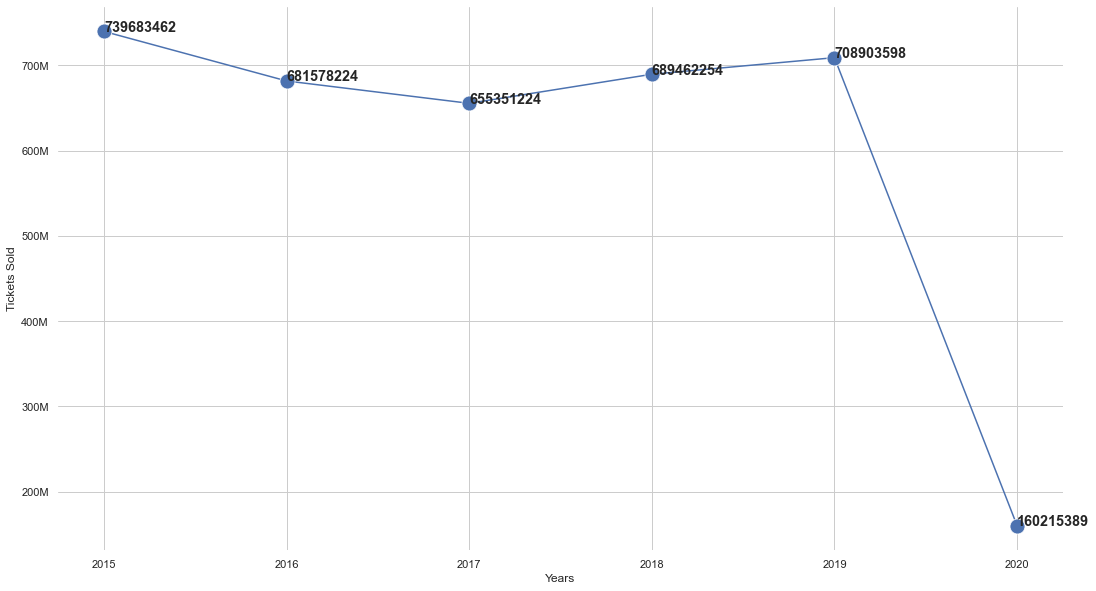

In [200]:
def millions_no_currency(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x*1e-6)
df_movies_2015_2020 = [df_2015,df_2016,df_2017,df_2018,df_2019,df_2020]
domestic_gross_2015_2020 = []
tickets_sold_2015_2020 = []
worldwide_gross_2015_2020 = []
for df in df_movies_2015_2020:
    domestic_gross_2015_2020.append(int(df['Domestic Gross'].astype('int64').mean()))
    worldwide_gross_2015_2020.append(int(df['Worldwide Gross'].astype('int64').mean()))
    tickets_sold_2015_2020.append(df['Tickets Sold'].astype('int64').sum())
df = pd.DataFrame(data={'Years':['2015','2016','2017','2018','2019','2020'],'Tickets Sold':average_tickets_sold_2015_2020})
f, ax = plt.subplots(figsize=(18, 10))
sns.lineplot(x='Years',y='Tickets Sold',markers=True,marker="o", data=df, markersize=15)
ax.yaxis.set_major_formatter( FuncFormatter(millions_no_currency))
for index,year in enumerate(['2015','2016','2017','2018','2019','2020']):
    ax.text(year,average_tickets_sold_2015_2020[index],f'{float(average_tickets_sold_2015_2020[index]):.0f}',fontsize='x-large',fontweight='bold')
    sns.despine(left=True, bottom=True)
    


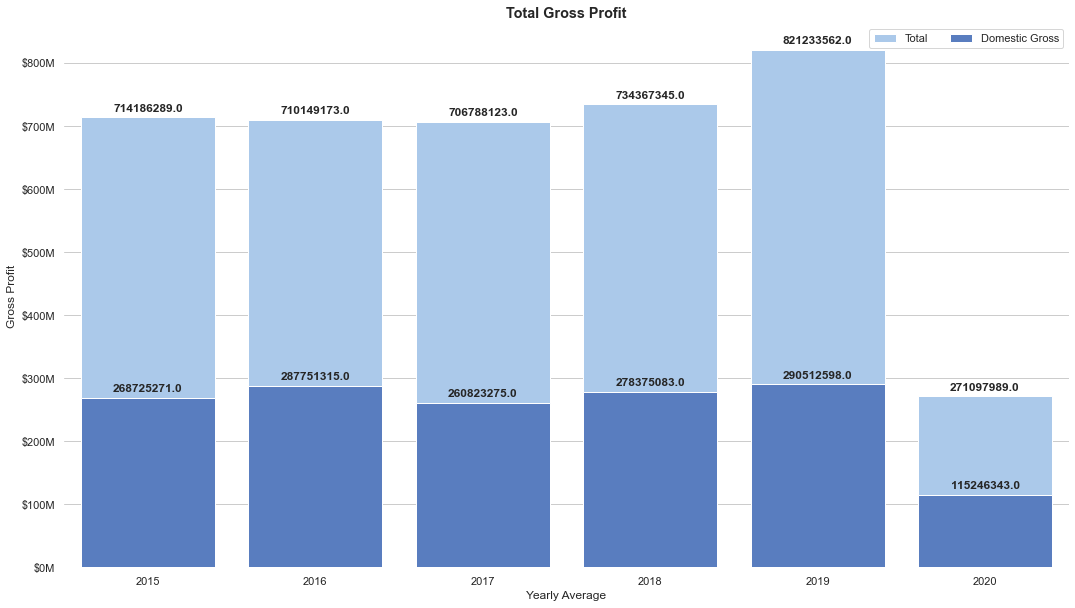

In [249]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 10))

# data with the domestic gross and worldwide gross of top 25 movies from 2015 - 2020
df2 = pd.DataFrame(data={'Years':['2015','2016','2017','2018','2019','2020'],'Domestic Gross':domestic_gross_2015_2020,'Worldwide Gross':worldwide_gross_2015_2020})
df2
# Plot the gross profit
sns.set_color_codes("pastel")
ax1 = sns.barplot(y="Worldwide Gross", x="Years", data=df2,
            label="Total", color="b")



# Plot the domestic gross profit
sns.set_color_codes("muted")
ax2 = sns.barplot(y="Domestic Gross", x="Years", data=df2,
            label="Domestic Gross", color="b")

for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',fontsize='medium',fontweight='bold')


# # Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="Gross Profit",xlabel="Yearly Average")
ax.set_title("Total Gross Profit",fontsize='large',fontweight='bold')
ax.yaxis.set_major_formatter( FuncFormatter(millions))
sns.despine(left=True, bottom=True)



In [253]:
years = ['2015','2016','2017','2018','2019','2020']
total_gross_variance_by_year =[]
domestic_gross_variance_by_year=[]
for index in range(len(domestic_gross_2015_2020)):
    if(index == 0):
        total_gross_variance_by_year.append(0)
        domestic_gross_variance_by_year.append(0)
        continue
    prev_index = index-1
    total_gross_variance_by_year.append((domestic_gross_2015_2020[index]/domestic_gross_2015_2020[prev_index] -1))
    domestic_gross_variance_by_year.append((worldwide_gross_2015_2020[index]/worldwide_gross_2015_2020[prev_index]-1))
print(domestic_gross_variance_by_year)
print(total_gross_variance_by_year)
df= pd.DataFrame(data = {'Year':years,"Domestic Gross Variance":domestic_gross_variance_by_year,'Total Gross Varian':total_gross_variance_by_year})
total_gross_variance = np.var(domestic_gross_2015_2020)
domestic_gross_variance = np.var(worldwide_gross_2015_2020)
print(f"domestic variance: {domestic_gross_variance}")
print(f"total variance: {total_gross_variance}")
df

[0, -0.005652749236691124, -0.00473287884825857, 0.039020494406355466, 0.11828714551570907, -0.6698892963656057]
[0, 0.07080109708029658, -0.0935809450601468, 0.06729387168380585, 0.04360129818084335, -0.6033000159256432]
domestic variance: 3.173516155576784e+16
total variance: 3749593695964371.5


,Year,Domestic Gross Variance,Total Gross Varian
0,2015,0.00,0.00
1,2016,-0.01,0.07
2,2017,-0.00,-0.09
3,2018,0.04,0.07
4,2019,0.12,0.04
5,2020,-0.67,-0.60


In [1]:
top_25_movies_2015_2020 = pd.concat(df_movies_2015_2020,ignore_index=True)
top_25_movies_2015_2020 = top_25_movies_2015_2020.astype({'Worldwide Gross':'int64','International Gross':'int64'})
group_movies = top_25_movies_2015_2020.groupby('Source').agg({'Worldwide Gross':'mean','International Gross':'mean'})
group_movies 

NameError: name 'pd' is not defined

In [2]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 10))
g = sns.barplot(y=group_movies.index, x=group_movies["Worldwide Gross"], palette="muted",orient="h")
g.xaxis.set_major_formatter( FuncFormatter(millions))
g.set_title("Movie Average WorldWide Gross by Source",fontsize='large',fontweight='bold')

NameError: name 'sns' is not defined